In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Node:
    def __init__(self, feature_col=None, threshold=None, left=None, right=None, pred_class=None):
        self.feature_col = feature_col
        self.threshold = threshold
        self.left = left
        self.right = right
        self.pred_class = pred_class #Exists only when it's leaf node
        
def calculate_entropy(data):
    unique_vals, counts = np.unique(data, return_counts=True)
    probs = counts/len(data)
    return -np.sum(probs*np.log2(probs))

def calculate_gain_ratio(data, feature, split_val):
    if len(data) == 0:
        return 0
    entire_ds_entropy = calculate_entropy(data)
    data_left = data[data[feature] >= split_val]
    data_right = data[data[feature] < split_val]
    if len(data_left) == 0 or len(data_right) == 0:
        return 0
    info_gain = entire_ds_entropy - len(data_left)/len(data)*calculate_entropy(data_left) - len(data_right)/len(data)*calculate_entropy(data_right)
    split_entropy = -len(data_left)/len(data)*np.log2(len(data_left)/len(data))-len(data_right)/len(data)*np.log2(len(data_right)/len(data))
    if split_entropy == 0:
        return 0
    return info_gain/split_entropy

def best_split(data, feature):
    unique_vals = data[feature].unique()
    all_gain_ratios = [calculate_gain_ratio(data, feature, unique_vals[i]) for i in range(len(unique_vals))]
    best_split_val = unique_vals[np.argmax(all_gain_ratios)]
    max_gain_ratio = np.max(all_gain_ratios)
    return best_split_val, max_gain_ratio

def best_feature_tosplit(data):
    all_gain_ratios_splits = [best_split(data, feature) for feature in data.columns[:-1]]
    max_gain_ratio_ind = np.argmax([gain_ratio[1] for gain_ratio in all_gain_ratios_splits])
    return data.columns[:-1][max_gain_ratio_ind], all_gain_ratios_splits[max_gain_ratio_ind][0], all_gain_ratios_splits[max_gain_ratio_ind][1]

In [3]:
def build_tree(data):
    stop = False
    
    if len(data) == 0:
        stop = True
    
    best_feature, best_split_val, best_gain_ratio = best_feature_tosplit(data)
    #print(best_feature, best_split_val, best_gain_ratio)
    
    one_class_len = data[data['y'] == 1].shape[0]
    zero_class_len = data[data['y'] == 0].shape[0]
        
    if best_gain_ratio == 0 or one_class_len == 0 or zero_class_len == 0:
        stop = True
    
    if stop:
        if one_class_len == zero_class_len:
            majority_class = 1
        else:
            majority_class = np.argmax([zero_class_len, one_class_len])
        leaf_node = Node(pred_class=majority_class)
        return leaf_node
    else:
        data_left = data[data[best_feature] >= best_split_val]
        data_right = data[data[best_feature] < best_split_val]
        tree_left = build_tree(data_left)
        tree_right = build_tree(data_right)
        new_node = Node(feature_col=best_feature, threshold=best_split_val, left=tree_left, right=tree_right)
        return new_node

In [4]:
def visualize_tree(node, depth=0, parent_direction=None):
    if node is None:
        return

    prefix = "  " * depth
    if node.left is None and node.right is None:
        print(prefix+"|-- " + parent_direction + " --> "+str(node.pred_class))

    if node.feature_col is not None:
        print(prefix + "|-- " + node.feature_col + " >= " + str(node.threshold))
        visualize_tree(node.left, depth + 1, "True")
        visualize_tree(node.right, depth + 1, "False")

### Question 2.2

In [16]:
q2_df = pd.DataFrame({'x1':[0,0,1,1], 'x2':[0,1,0,1], 'y':[0, 1, 1, 0]})

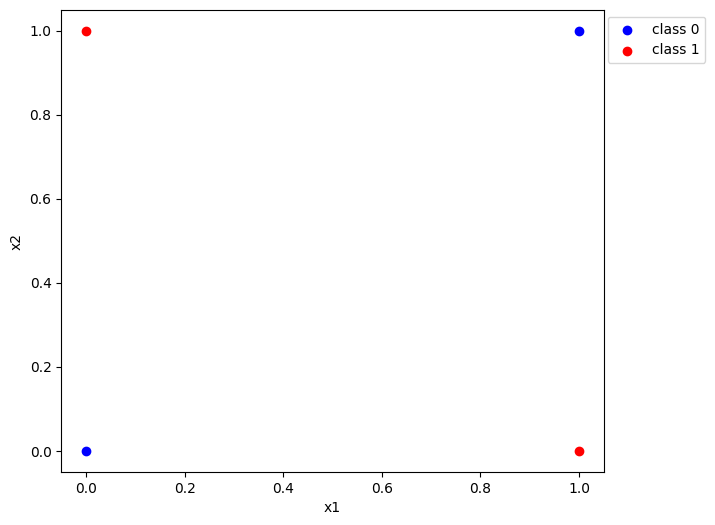

In [17]:
class_zero = q2_df[q2_df['y'] == 0]
class_one = q2_df[q2_df['y'] == 1]
    
plt.figure(figsize=(7, 6))
plt.scatter(class_zero['x1'], class_zero['x2'], label = "class 0", c='blue')
plt.scatter(class_one['x1'], class_one['x2'], label='class 1', c='red')
    
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

### Question 2.3

In [5]:
data_druns = pd.read_csv('Homework2data/Druns.txt', sep=' ', header=None, names=['x1', 'x2', 'y'])

In [6]:
visualize_tree(build_tree(data_druns))

|-- x1 >= 0.1
  |-- True --> 0
  |-- x2 >= 0
    |-- x2 >= 8
      |-- True --> 1
      |-- x2 >= 7
        |-- True --> 0
        |-- x2 >= 6
          |-- True --> 1
          |-- False --> 0
    |-- False --> 1


In [7]:
def get_infogain_list(data):
    list_of_infogain = []
    for feature in data.columns[:-1]:
        unique_values = data[feature].unique()
        for i in unique_values:
            entire_ds_entropy = calculate_entropy(data)
            data_left = data[data[feature] >= i]
            data_right = data[data[feature] < i]
            if len(data_left) == 0 or len(data_right) == 0:
                list_of_infogain.append((feature, i, 0))
            else:
                info_gain = entire_ds_entropy - len(data_left)/len(data)*calculate_entropy(data_left) - len(data_right)/len(data)*calculate_entropy(data_right)
                split_entropy = -len(data_left)/len(data)*np.log2(len(data_left)/len(data))-len(data_right)/len(data)*np.log2(len(data_right)/len(data))
                if split_entropy == 0:  
                    list_of_infogain.append((feature, i, info_gain))
                else:
                    list_of_infogain.append((feature, i, info_gain/split_entropy))
                    
    return list_of_infogain

In [8]:
left_tree = data_druns[data_druns['x1']>=0.1]
get_infogain_list(left_tree)

[('x1', 0.1, 0), ('x2', -2, 0)]

In [9]:
right_tree = data_druns[data_druns['x1']<0.1]
get_infogain_list(right_tree)

[('x1', 0.0, 0),
 ('x2', -1, 0),
 ('x2', 0, 1.1200475349745609),
 ('x2', 1, 0.6450849142193005),
 ('x2', 2, 0.6705393155765567),
 ('x2', 3, 0.7507229305159435),
 ('x2', 4, 0.8160630922912002),
 ('x2', 5, 0.8856467949833186),
 ('x2', 6, 0.9852644418937408),
 ('x2', 7, 0.9297777447158698),
 ('x2', 8, 1.1200475349745609)]

In [10]:
get_infogain_list(data_druns)

[('x1', 0.1, 1.830900511337223),
 ('x1', 0.0, 0),
 ('x2', -2, 0),
 ('x2', -1, 1.830900511337223),
 ('x2', 0, 1.3428806040488561),
 ('x2', 1, 0.9521010909055795),
 ('x2', 2, 0.881269916985436),
 ('x2', 3, 0.900007416231883),
 ('x2', 4, 0.9279141812771867),
 ('x2', 5, 0.9720633188895438),
 ('x2', 6, 1.0527437522900642),
 ('x2', 7, 0.9797988269341698),
 ('x2', 8, 1.1596553473089832)]

### Question 2.4

In [8]:
data_d3leaves = pd.read_csv('Homework2data/D3leaves.txt', sep=' ', header=None, names=['x1', 'x2', 'y'])

In [9]:
visualize_tree(build_tree(data_d3leaves))

|-- x1 >= 10
  |-- True --> 1
  |-- x2 >= 3
    |-- True --> 1
    |-- False --> 0


### Question 2.5

In [10]:
d1_tree = pd.read_csv('Homework2data/D1.txt', sep=' ', header=None, names=['x1', 'x2', 'y'])
visualize_tree(build_tree(d1_tree))

|-- x2 >= 0.201829
  |-- True --> 1
  |-- False --> 0


In [11]:
d2_tree = pd.read_csv('Homework2data/D2.txt', sep=' ', header=None, names=['x1', 'x2', 'y'])
visualize_tree(build_tree(d2_tree))                      

|-- x1 >= 0.533076
  |-- x2 >= 0.228007
    |-- x2 >= 0.424906
      |-- True --> 1
      |-- x1 >= 0.708127
        |-- True --> 1
        |-- x2 >= 0.32625
          |-- x1 >= 0.595471
            |-- x1 >= 0.646007
              |-- True --> 1
              |-- x2 >= 0.403494
                |-- True --> 1
                |-- False --> 0
            |-- False --> 0
          |-- False --> 0
    |-- x1 >= 0.887224
      |-- x2 >= 0.037708
        |-- x2 >= 0.082895
          |-- True --> 1
          |-- x1 >= 0.960783
            |-- True --> 1
            |-- False --> 0
        |-- False --> 0
      |-- x1 >= 0.850316
        |-- x2 >= 0.169053
          |-- True --> 1
          |-- False --> 0
        |-- False --> 0
  |-- x2 >= 0.88635
    |-- x1 >= 0.041245
      |-- x1 >= 0.104043
        |-- True --> 1
        |-- x2 >= 0.964767
          |-- True --> 1
          |-- False --> 0
      |-- False --> 0
    |-- x2 >= 0.691474
      |-- x1 >= 0.254049
        |-- True --> 1
      

### Question 2.6

In [12]:
def get_scatterplot(data):
    class_zero = data[data['y'] == 0]
    class_one = data[data['y'] == 1]
    
    plt.figure(figsize=(7, 6))
    plt.scatter(class_zero['x1'], class_zero['x2'], label = "class 0", c='blue')
    plt.scatter(class_one['x1'], class_one['x2'], label='class 1', c='red')
    
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    
    plt.show()

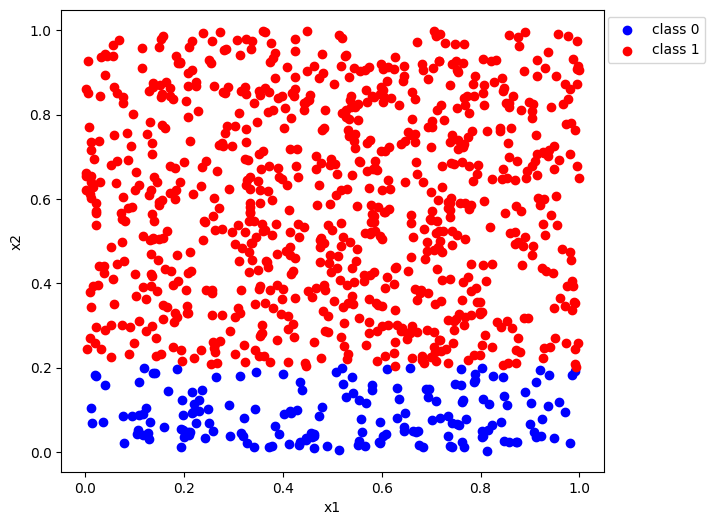

In [13]:
get_scatterplot(d1_tree)

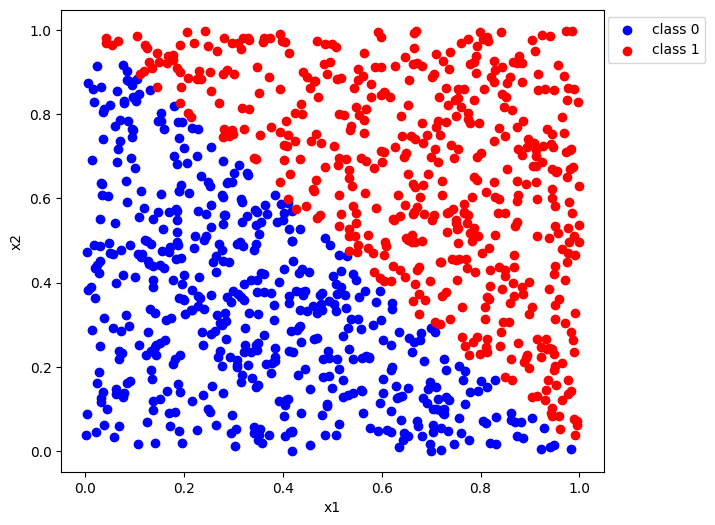

In [14]:
get_scatterplot(d2_tree)

In [84]:
from matplotlib.patches import Rectangle

def plot_decision_boundary(tree, data, features):
    x_min, x_max = data[features[0]].min()-0.02, data[features[0]].max()+0.02
    y_min, y_max = data[features[1]].min()-0.02, data[features[1]].max()+0.02
    
    class_zero = data[data['y'] == 0]
    class_one = data[data['y'] == 1]
    
    plt.figure(figsize=(7, 6))
    plt.scatter(class_zero['x1'], class_zero['x2'], label = "class 0", c='blue')
    plt.scatter(class_one['x1'], class_one['x2'], label='class 1', c='red')
    
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

    plot_tree_boundaries(tree, plt.gca(), x_min, x_max, y_min, y_max)

    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.show()

def plot_tree_boundaries(node, ax, x_min, x_max, y_min, y_max):
    if node.pred_class is not None:
        if node.pred_class == 1:
            ax.add_patch(Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=2, ec='red', fill=True, facecolor='red', alpha=0.2))
        elif node.pred_class == 0:
            ax.add_patch(Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=2, ec='blue', fill=True, facecolor='blue', alpha=0.2))
    elif node.feature_col is not None:
        if node.feature_col == 'x1':
            plot_tree_boundaries(node.left, ax, node.threshold, x_max, y_min, y_max)
            plot_tree_boundaries(node.right, ax, x_min, node.threshold, y_min, y_max)
        elif node.feature_col == 'x2':
            plot_tree_boundaries(node.left, ax, x_min, x_max, node.threshold, y_max)
            plot_tree_boundaries(node.right, ax, x_min, x_max, y_min, node.threshold)


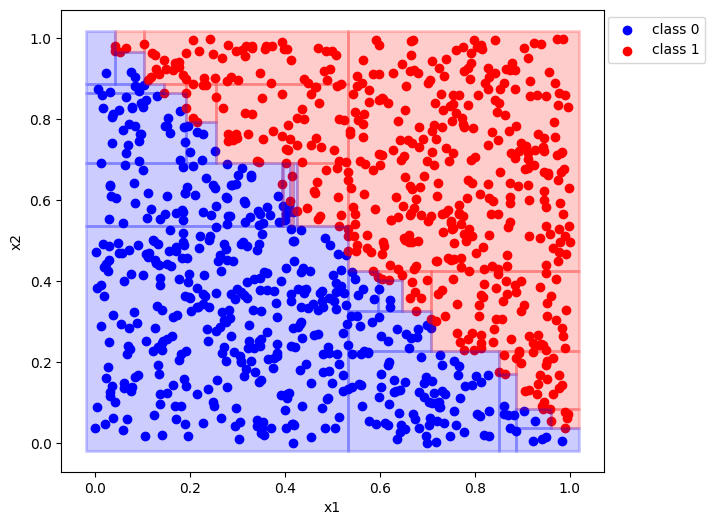

In [85]:
plot_decision_boundary(build_tree(d2_tree), d2_tree, ['x1', 'x2'])

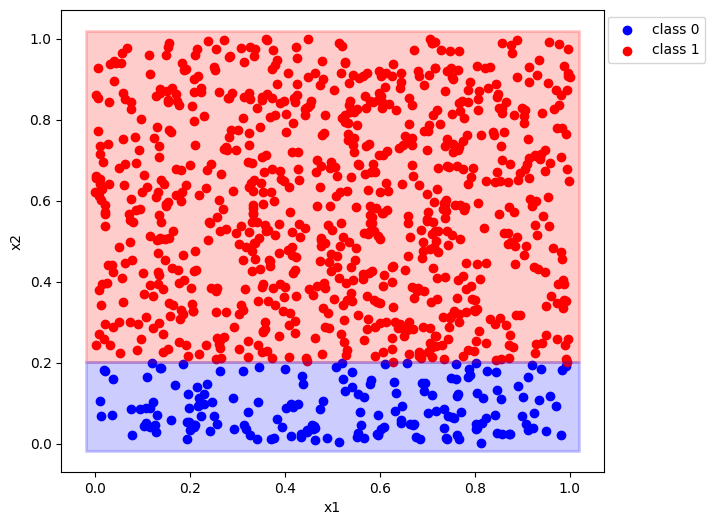

In [86]:
plot_decision_boundary(build_tree(d1_tree), d1_tree, ['x1', 'x2'])

### Question 2.7

In [123]:
def predict(tree, data_point):
    if tree.pred_class is not None:
        return tree.pred_class
    else:
        if data_point[tree.feature_col] >= tree.threshold:
            return predict(tree.left, data_point)
        else:
            return predict(tree.right, data_point)

def count_nodes(tree):
    if tree is None:
        return 0
    return 1+count_nodes(tree.left)+count_nodes(tree.right)

In [124]:
d_big = pd.read_csv('Homework2data/Dbig.txt', sep=' ', header=None, names=['x1', 'x2', 'y'])

In [126]:
shuffled_d_big = d_big.sample(frac=1.0, random_state=42).reset_index(drop=True)
train_big = shuffled_d_big.iloc[:8192]
test_big = shuffled_d_big.iloc[8192:].reset_index(drop=True)

d_32 = train_big.iloc[:32]
d_128 = train_big.iloc[:128]
d_512 = train_big.iloc[:512]
d_2048 = train_big.iloc[:2048]
d_8192 = train_big.iloc[:8192]

In [127]:
def cal_accuracy(tree, test_data):
    correct_predicted_class = 0
    for index, row in test_data.iterrows():
        pred_class = predict(tree, row[['x1', 'x2']])
        if pred_class == row['y']:
            correct_predicted_class += 1
    return correct_predicted_class/len(test_data)

In [128]:
data_size = [32, 128, 512, 2048, 8192]
num_nodes = []
error = []

In [129]:
d_32_tree = build_tree(d_32)
num_nodes.append(count_nodes(d_32_tree))
error.append(1-cal_accuracy(d_32_tree, test_big))

In [130]:
d_128_tree = build_tree(d_128)
num_nodes.append(count_nodes(d_128_tree))
error.append(1-cal_accuracy(d_128_tree, test_big))

In [131]:
d_512_tree = build_tree(d_512)
num_nodes.append(count_nodes(d_512_tree))
error.append(1-cal_accuracy(d_512_tree, test_big))

In [132]:
d_2048_tree = build_tree(d_2048)
num_nodes.append(count_nodes(d_2048_tree))
error.append(1-cal_accuracy(d_2048_tree, test_big))

In [133]:
d_8192_tree = build_tree(d_8192)
num_nodes.append(count_nodes(d_8192_tree))
error.append(1-cal_accuracy(d_8192_tree, test_big))

In [134]:
num_nodes

[9, 25, 57, 115, 277]

In [135]:
error

[0.13440265486725667,
 0.12942477876106195,
 0.05530973451327437,
 0.028761061946902644,
 0.022676991150442527]

In [139]:
from tabulate import tabulate
data = list(zip(data_size, num_nodes, error))

headers = ["Dataset Size", "Number of Nodes", "Error"]

table = tabulate(data, headers=headers, tablefmt="fancy_grid")
print(table)

╒════════════════╤═══════════════════╤═══════════╕
│   Dataset Size │   Number of Nodes │     Error │
╞════════════════╪═══════════════════╪═══════════╡
│             32 │                 9 │ 0.134403  │
├────────────────┼───────────────────┼───────────┤
│            128 │                25 │ 0.129425  │
├────────────────┼───────────────────┼───────────┤
│            512 │                57 │ 0.0553097 │
├────────────────┼───────────────────┼───────────┤
│           2048 │               115 │ 0.0287611 │
├────────────────┼───────────────────┼───────────┤
│           8192 │               277 │ 0.022677  │
╘════════════════╧═══════════════════╧═══════════╛


Text(0, 0.5, 'Test set error')

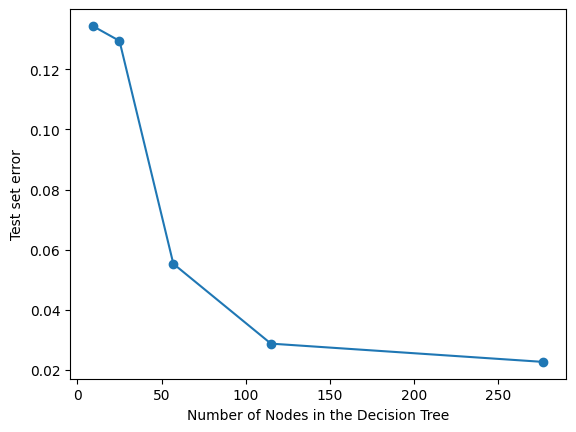

In [143]:
plt.plot(num_nodes, error, marker='o')
plt.xlabel("Number of Nodes in the Decision Tree")
plt.ylabel("Test set error")

Text(0, 0.5, 'Test set error')

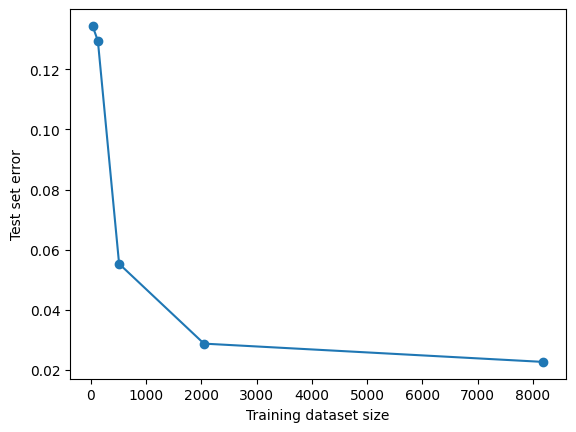

In [144]:
plt.plot(data_size, error, marker='o')
plt.xlabel("Training dataset size")
plt.ylabel("Test set error")

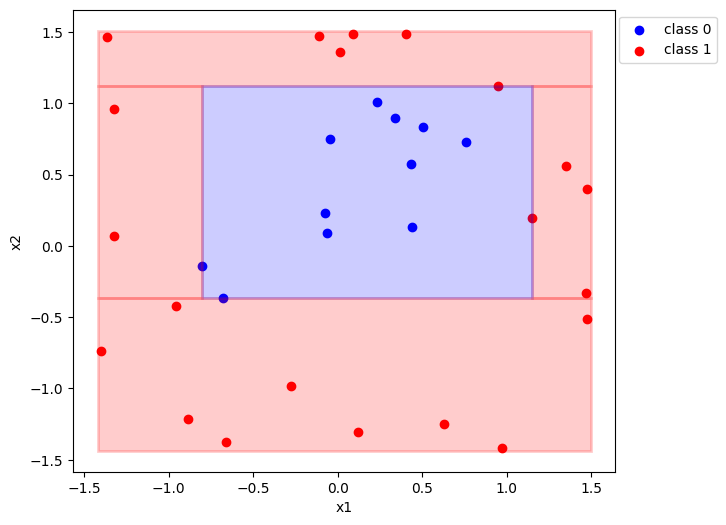

In [145]:
plot_decision_boundary(d_32_tree, d_32, ['x1', 'x2'])

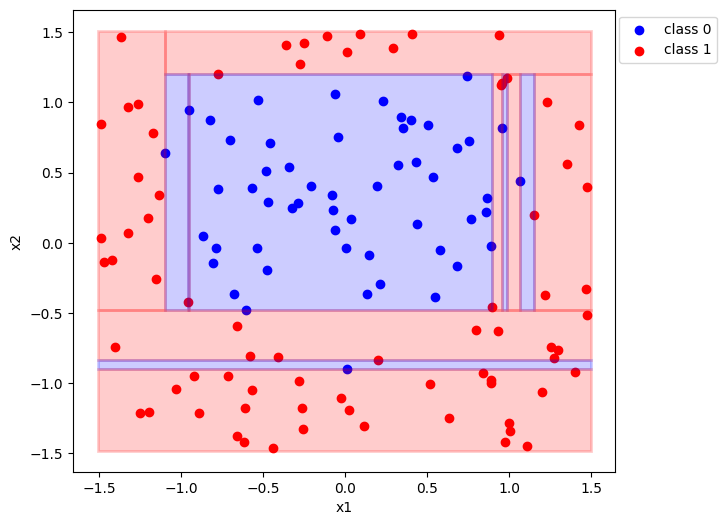

In [150]:
plot_decision_boundary(d_128_tree, d_128, ['x1', 'x2'])

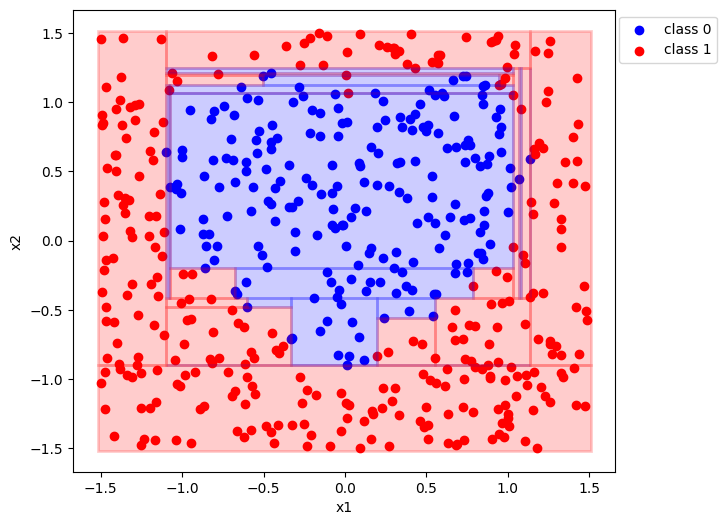

In [151]:
plot_decision_boundary(d_512_tree, d_512, ['x1', 'x2'])

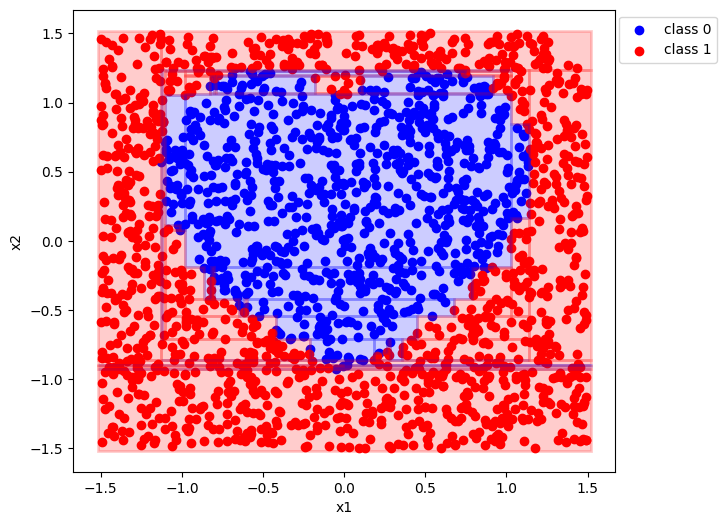

In [152]:
plot_decision_boundary(d_2048_tree, d_2048, ['x1', 'x2'])

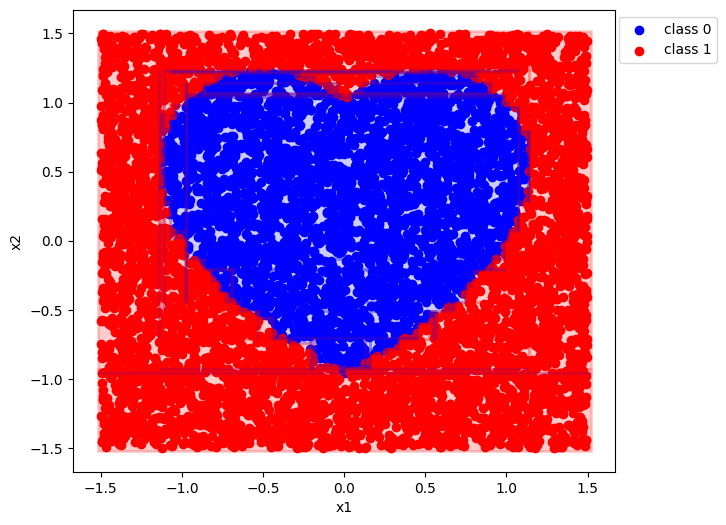

In [153]:
plot_decision_boundary(d_8192_tree, d_8192, ['x1', 'x2'])

### Question 3

In [154]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [169]:
def count_tree_nodes_scikit(tree):
    if tree.children_left[0] == tree.children_right[0]:  # Leaf node
        return 1
    else:
        left_count = count_tree_nodes_scikit(tree.children_left)
        right_count = count_tree_nodes_scikit(tree.children_right)
        return 1 + left_count + right_count

In [176]:
scikit_errors = []
scikit_num_nodes = []

In [177]:
clf_32 = DecisionTreeClassifier()
clf_32.fit(d_32[['x1', 'x2']], d_32['y'])
pred_32 = clf_32.predict(test_big[['x1', 'x2']])
scikit_errors.append(1-accuracy_score(test_big['y'], pred_32))
scikit_num_nodes.append(clf_32.tree_.node_count)

In [178]:
clf_128 = DecisionTreeClassifier()
clf_128.fit(d_128[['x1', 'x2']], d_128['y'])
pred_128 = clf_128.predict(test_big[['x1', 'x2']])
scikit_errors.append(1-accuracy_score(test_big['y'], pred_128))
scikit_num_nodes.append(clf_128.tree_.node_count)

In [179]:
clf_512 = DecisionTreeClassifier()
clf_512.fit(d_512[['x1', 'x2']], d_512['y'])
pred_512 = clf_512.predict(test_big[['x1', 'x2']])
scikit_errors.append(1-accuracy_score(test_big['y'], pred_512))
scikit_num_nodes.append(clf_512.tree_.node_count)

In [180]:
clf_2048 = DecisionTreeClassifier()
clf_2048.fit(d_2048[['x1', 'x2']], d_2048['y'])
pred_2048 = clf_2048.predict(test_big[['x1', 'x2']])
scikit_errors.append(1-accuracy_score(test_big['y'], pred_2048))
scikit_num_nodes.append(clf_2048.tree_.node_count)

In [181]:
clf_8192 = DecisionTreeClassifier()
clf_8192.fit(d_8192[['x1', 'x2']], d_8192['y'])
pred_8192 = clf_8192.predict(test_big[['x1', 'x2']])
scikit_errors.append(1-accuracy_score(test_big['y'], pred_8192))
scikit_num_nodes.append(clf_8192.tree_.node_count)

In [182]:
from tabulate import tabulate
data = list(zip(data_size, scikit_num_nodes, scikit_errors))

headers = ["Dataset Size", "Numer of nodes", "Error"]

table = tabulate(data, headers=headers, tablefmt="fancy_grid")
print(table)

╒════════════════╤══════════════════╤═══════════╕
│   Dataset Size │   Numer of nodes │     Error │
╞════════════════╪══════════════════╪═══════════╡
│             32 │                9 │ 0.10177   │
├────────────────┼──────────────────┼───────────┤
│            128 │               21 │ 0.0990044 │
├────────────────┼──────────────────┼───────────┤
│            512 │               59 │ 0.0470133 │
├────────────────┼──────────────────┼───────────┤
│           2048 │              105 │ 0.0215708 │
├────────────────┼──────────────────┼───────────┤
│           8192 │              229 │ 0.0160398 │
╘════════════════╧══════════════════╧═══════════╛


Text(0, 0.5, 'Test set error')

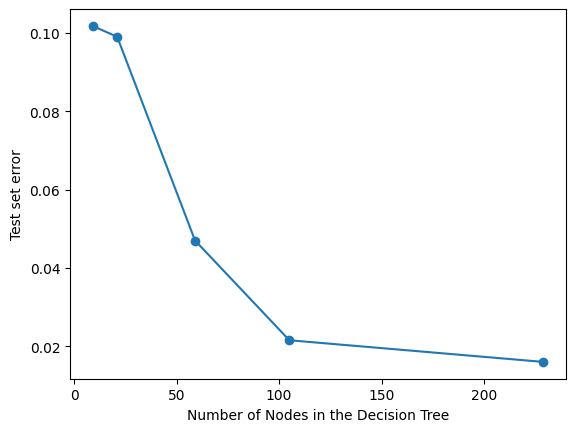

In [184]:
plt.plot(scikit_num_nodes, scikit_errors, marker='o')
plt.xlabel("Number of Nodes in the Decision Tree")
plt.ylabel("Test set error")

Text(0, 0.5, 'Test set error')

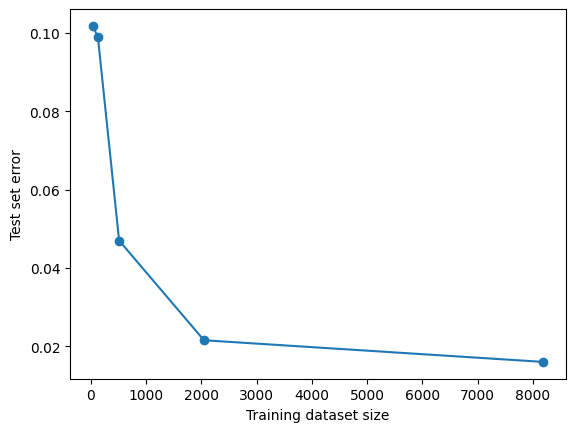

In [185]:
plt.plot(data_size, scikit_errors, marker='o')
plt.xlabel("Training dataset size")
plt.ylabel("Test set error")

### Question 4

In [201]:
from scipy.interpolate import lagrange

a, b = 0, 2 * np.pi
n = 100

x_train = np.random.uniform(a, b, n)
y_train = np.sin(x_train)

Text(0, 0.5, 'Y')

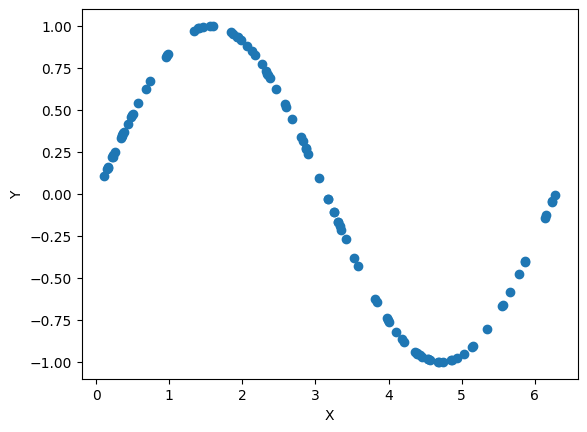

In [202]:
plt.scatter(x_train, y_train)
plt.xlabel("X")
plt.ylabel("Y")

In [203]:
lagrange_poly = lagrange(x_train, y_train)

In [204]:
x_test = np.random.uniform(a, b, n)
y_test = np.sin(x_test)

y_train_predicted = lagrange_poly(x_train)
y_test_predicted = lagrange_poly(x_test)

In [205]:
training_error = np.mean((y_train-y_train_predicted)**2)
test_error = np.mean((y_test-y_test_predicted)**2)

In [206]:
np.log(training_error), np.log(test_error)

(335.60685884556983, 335.21644150340404)

In [225]:
std_devs = np.arange(0, 50, 0.5)

In [226]:
train_errors = []
test_errors = []

for std in std_devs:
    epsilon = np.random.normal(0, std, n)
    new_x_train = x_train+epsilon
    new_y_train = np.sin(new_x_train)
    
    lagrange_ = lagrange(new_x_train, new_y_train)
    
    y_train_predicted = lagrange_(new_x_train)
    y_test_predicted = lagrange_(x_test)
    
    train_errors.append(np.log(np.mean((new_y_train-y_train_predicted)**2)))
    test_errors.append(np.log(np.mean((y_test-y_test_predicted)**2)))

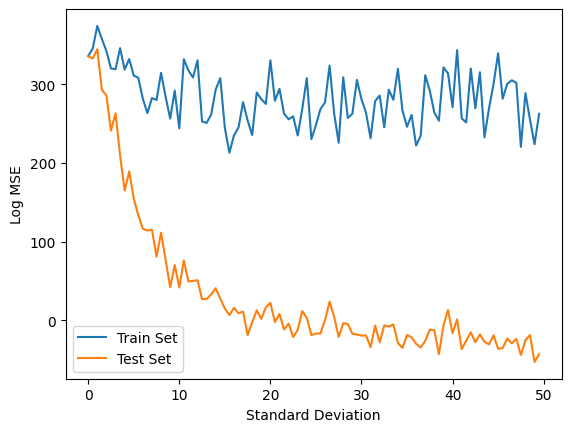

In [228]:
plt.plot(std_devs, train_errors)
plt.plot(std_devs, test_errors)
plt.ylabel("Log MSE")
plt.xlabel("Standard Deviation")
plt.legend(["Train Set", "Test Set"])